In [24]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
import tf_slim
from collections import deque, Counter
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
!pip install keras==2.6.*
!pip install gym[all]
!pip install PyVirtualDisplay

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)
  Running setup.py clean for box2d-py
  Running setup.py clean for mujoco-py
Failed to build box2d-py mujoco-py
    Running setup.py install for mujoco-py: started
    Running setup.py install for mujoco-py: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\program files\python38\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\ASUS\\AppData\\Local\\Temp\\pip-install-a9doixbp\\box2d-py_8571d31cd0044d57a466702bf5681634\\setup.py'"'"'; __file__='"'"'C:\\Users\\ASUS\\AppData\\Local\\Temp\\pip-install-a9doixbp\\box2d-py_8571d31cd0044d57a466702bf5681634\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\ASUS\AppData\Local\Temp\pip-wheel-4r0n5p2b'
       cwd: C:\Users\ASUS\AppData\Local\Temp\pip-install-a9doixbp\box2d-py_8571d31cd0044d57a466702bf5681634\
  Complete output (16 lines):
  Using setuptools (version 59.2.0).
  running bdist_wheel
  running build
  running build_py
  creating build
  c

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [25]:
# تهيئة بيئة عمل اللعبة
env = gym.make("SpaceInvaders-v0")
# معاينة عدد الأفعال الممكنة
n_outputs = env.action_space.n
print(n_outputs)
# معاينة أسماء الأفعال الممكنة
print(env.get_action_meanings())

6
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


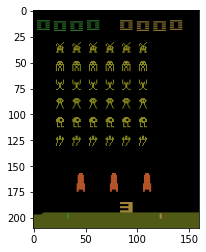

In [26]:
# التهيئة الأولية
state = env.reset()
# معاينة الوضع الأولي للعبة
plt.imshow(state)
plt.show()

RIGHTFIRE  ==>  5.0  ,( 0.0 )
RIGHT  ==>  10.0  ,( 5.0 )
RIGHT  ==>  15.0  ,( 15.0 )
LEFT  ==>  15.0  ,( 30.0 )
LEFT  ==>  5.0  ,( 45.0 )
LEFTFIRE  ==>  10.0  ,( 50.0 )
NOOP  ==>  20.0  ,( 60.0 )
RIGHTFIRE  ==>  20.0  ,( 80.0 )
RIGHTFIRE  ==>  25.0  ,( 100.0 )
LEFTFIRE  ==>  30.0  ,( 125.0 )
Reward: 155.0


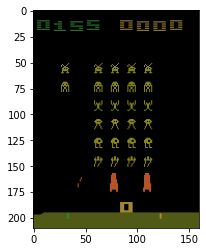

In [27]:
env.reset()
# المكافآة الإجمالية
episode_reward = 0 
while True:
    # اختيار فعل بشكل عشوائي
    action = env.action_space.sample()
    # تنفيذ الفعل
    # الانتقال لحالة جديدة
    state, reward, done, info = env.step(action)
    if (reward>0):
        # طباعة القيم في حال مكافآة أكبر من الصفر
        print(env.get_action_meanings()[action]," ==> ",  reward, " ,(",episode_reward,")" )
    # إضافة مكافآة الفعل للمكافآة الإجمالية
    episode_reward += reward
    # اختبار نهاية اللعبة
    if done:
        # طباعة المكافآة النهائية
        print('Reward: %s' % episode_reward)
        break
# معاينة الوضع النهائي للعبة
plt.imshow(state)
plt.show()

In [28]:
def preprocess_state(state):
    # نحجيم الصورة واقتطاع الجزء الهام منها
    img = state[25:201:2, ::2]
    # تحويل الصورة إلى درجات الرمادي
    img = img.mean(axis=2)
    color = np.array([210, 164, 74]).mean()
    # تحسين التباين في الصورة
    img[img==color] = 0
    # تطبيع القيم من -1 إلى +1
    img = (img - 128) / 128 - 1
    return img.reshape(88,80)

(210, 160, 3)
(88, 80)


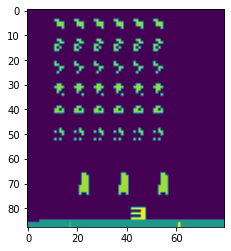

In [29]:
# التهيئة الأولية
state = env.reset()
# معاينة الصورة بعد عمليات التهيئة
state_preprocessed = preprocess_state(state).reshape(88,80)
print(state.shape)
print(state_preprocessed.shape)
plt.imshow(state_preprocessed)
plt.show()

In [30]:
# نستخدم 4 صور متعاقبة لملاحقة الحركة
stack_size = 4 
# تهيئة قائمة مفتوحة الطرفين
# تحوي أربعة صور ذات قيم 0
stacked_frames  =  deque([np.zeros((88,80), dtype=np.int) for i in range(stack_size)], maxlen=4)
def stack_frames(stacked_frames, state, is_new_episode):
    # المعالجة الأولية للصورة
    frame = preprocess_state(state)
    # إذا حلقة جديدة
    if is_new_episode:
        # مسح الصور السابقة المكدّسة
        stacked_frames = deque([np.zeros((88,80), dtype=np.int) for i in range(stack_size)], maxlen=4)
        # تكرار الصورة المعالجة في كل حلقة جديدة من اللعبة
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        # تكديس الصور
        stacked_state = np.stack(stacked_frames, axis=2)     
    else:
        # بما أن القائمة مفتوحة الطرفين تضيف من أقصى اليمين
        # نُحضر الصورة أقصى اليمين
        frame=stacked_frames[-1]
        # إضافة الصورة 
        stacked_frames.append(frame)
        # إنشاء الحالة
        stacked_state = np.stack(stacked_frames, axis=2) 
    return stacked_state, stacked_frames

In [31]:
def q_network(X, name_scope):
    # تهيئة الطبقات
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)
    with tf.compat.v1.variable_scope(name_scope) as scope: 
        # تهيئة الطبقات التلافيفية
        layer_1 = tf_slim.conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        layer_2 = tf_slim.conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        layer_3 = tf_slim.conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        # تسطيح نتيجة الطبقة الثالثة قبل تمريرها إلى الطبقة
        # التالية الموصولة بشكل كامل
        flat = tf_slim.flatten(layer_3)
        # إدراج الطبقة الموصولة بشكل كامل
        fc = tf_slim.fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        # إضافة طبقة الخرج النهائية
        output = tf_slim.fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        # تخزين معاملات الشبكة كأوزان
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
    	# إرجاع كل من المتغيرات والخرج
        return vars, output

In [32]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000
# تعريف سياسة إبسلون الشرهة
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #متحهة أحادية
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if p< epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [33]:
buffer_len = 20000
# نستخدم لذاكرة التخزين المؤقت قائمة مفتوحة الطرفين
exp_buffer = deque(maxlen=buffer_len)

In [34]:
# اختيار مجموعة عشوائية من تجارب التدريب
# بطول حجم دفعة التدريب 
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

Now we define our network hyperparameters,

In [35]:
num_episodes = 20000
batch_size = 48
input_shape = (None, 88, 80, 1)
learning_rate = 0.001
# التعديل لملائمة الصور المكدسة
X_shape = (None, 88, 80, 4)
discount_factor = 0.97
global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [36]:
tf.compat.v1.reset_default_graph()
# تعريف حاويةدخل الشبكة العصبية أي حالة اللعبة
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)
# تعريف متغير بولياني لقلب حالة التدريب 
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [37]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
# بناء الشبكةالتي تولد جميع قيم التعلم لجميع الأفعال في الحالة
mainQ, mainQ_outputs = q_network(X, 'mainQ')
# بشكل مشابهة نبني الشبكة الهدف لقيم التعلم
# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')
# تعريف حاوية قيم الأفعال
X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)
# نسخ قيم معاملات الشبكة إلى الشبكة الهدف
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [38]:
# تعريف حاوبة الخرج
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))
# حساب الخسارة والتي هي الفرق بين القيمة الحقيقية والقيمة المتوقعة
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))
# تحسين الخسارة
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [39]:
with tf.compat.v1.Session() as sess:
    init = tf.compat.v1.global_variables_initializer()
    init.run()
    # من أجل كل دورة
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []
        # تكديس الصور في الخطوة الأولى
        obs,stacked_frames= stack_frames(stacked_frames,obs,True)
        # الدوران طالما لم نصل للحالة النهائية
        while not done:
            #توليد البيانات باستخدام الشبكة غير المدربة
            # إدخال صورة اللعبة والحصول على قيم التعلم
            # من أجل كل فعل
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})
            # اختيار  الفعل
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 
            # استخدام سياسة ابسلون الشرهة لاختيار الفعل
            action = epsilon_greedy(action, global_step)
            # تنفيذ الفعل
            # والانتقال للحالة التالية وحساب المكافآة
            next_obs, reward, done, _ = env.step(action)
            # تكديس مابين الدورات
            next_obs, stacked_frames = stack_frames(stacked_frames, next_obs, False)
            # تخزين الانتقال كتجربة في
            # الذاكرة المؤقتة لإعادة اللعب
            exp_buffer.append([obs, action, next_obs, reward, done])
            # تدريب الشبكة من الذاكرة المؤقتة لإعادة اللعب بعد عدة خطوات معينة
            if global_step % steps_train == 0 and global_step > start_steps:
                # تحوي الذاكرة المؤقتة لإعادة اللعب
                # كل ما تمت معالجته وتكديسه
                # mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)
                # الحالات
                o_obs = [x for x in o_obs]
                # الحالات التالية
                o_next_obs = [x for x in o_next_obs]
                # الأفعال التالية
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})
                # المكافآت
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # نسخ أوزان الشبكة الرئيسية إلى الشبكة الهدف
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        next_obs=np.zeros(obs.shape)
        exp_buffer.append([obs, action, next_obs, reward, done])
        obs= env.reset()
        obs,stacked_frames= stack_frames(stacked_frames,obs,True)  
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))

Epochs per episode: 505 Episode Reward: 30.0 Episode number: 1
Epochs per episode: 539 Episode Reward: 50.0 Episode number: 2
Epochs per episode: 662 Episode Reward: 120.0 Episode number: 3


<ipython-input-34-762d291a11cf>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mem = np.array(exp_buffer)[perm_batch]


Epochs per episode: 608 Episode Reward: 120.0 Episode number: 4
Epochs per episode: 615 Episode Reward: 120.0 Episode number: 5
Epochs per episode: 539 Episode Reward: 135.0 Episode number: 6
Epochs per episode: 343 Episode Reward: 50.0 Episode number: 7
Epochs per episode: 710 Episode Reward: 355.0 Episode number: 8
Epochs per episode: 583 Episode Reward: 125.0 Episode number: 9
Epochs per episode: 540 Episode Reward: 165.0 Episode number: 10
Epochs per episode: 928 Episode Reward: 435.0 Episode number: 11
Epochs per episode: 739 Episode Reward: 160.0 Episode number: 12
Epochs per episode: 848 Episode Reward: 165.0 Episode number: 13
Epochs per episode: 1168 Episode Reward: 315.0 Episode number: 14
Epochs per episode: 653 Episode Reward: 120.0 Episode number: 15
Epochs per episode: 659 Episode Reward: 210.0 Episode number: 16
Epochs per episode: 814 Episode Reward: 405.0 Episode number: 17
Epochs per episode: 370 Episode Reward: 50.0 Episode number: 18
Epochs per episode: 984 Episode 

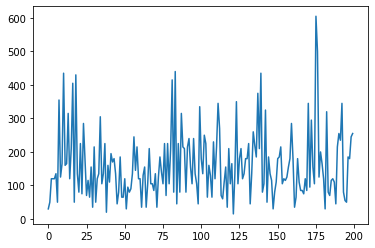

In [40]:
plt.plot(history)
plt.show()

In [41]:
# تسجيل فيديو بهدف التقييم
gymlogger.set_level(40) #error only
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# تقييم النموذج
environment = wrap_env(gym.make('SpaceInvaders-v0'))
done = False
observation = environment.reset()
new_observation = observation
prev_input = None
with tf.compat.v1.Session() as sess:
    init.run()
    observation, stacked_frames = stack_frames(stacked_frames, observation, True)
    while True:
        # الحصول على قيم التعلم
        actions = mainQ_outputs.eval(feed_dict={X:[observation], in_training_mode:False})
        # الحصول على الفعل
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 
        # اختيار الفعل باستخدام سياسة إبسلون الشرهة
        action = epsilon_greedy(action, global_step)
        environment.render()
        new_observation, stacked_frames = stack_frames(stacked_frames, new_observation, False)   
        observation = new_observation        
        # تنفيذ الفعل والانتقال للخطوة التالية
        new_observation, reward, done, _ = environment.step(action)
        if done: 
          break
    environment.close()